In [1]:
!python3.8 -m pip install numpy pandas seaborn mne scikit-learn pyriemann -q
print("INSTALLED")

INSTALLED


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
import mne

from mne import Epochs,find_events
from mne.decoding import Vectorizer
from mne import create_info
from mne.io import RawArray
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn

from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM


In [3]:
MYPATH = "/Users/rishabh/code/eeg/SPEAK_EEG/DATA/neurosity/visual-p300/2024_12_25_s01/rishabh_P300_02.csv"

df = pd.read_csv(MYPATH)
df.head

<bound method NDFrame.head of        EEG Channel 1  EEG Channel 2  EEG Channel 3  EEG Channel 4  \
0      -32002.375000   24199.761719  194540.625000   12673.236328   
1      -31710.953125   25818.609375  198430.687500   15089.839844   
2      -31621.367188   26915.095703  205806.765625   17297.767578   
3      -31885.363281   25449.738281  202754.890625   15197.865234   
4      -32028.056641   24176.158203  195459.015625   12768.455078   
...              ...            ...            ...            ...   
19854  -25948.830078   18152.519531  220334.546875   28528.578125   
19855  -25926.568359   18414.302734  225835.218750   29277.183594   
19856  -26082.269531   17677.701172  222478.578125   27772.330078   
19857  -26139.400391   17264.574219  216590.593750   26750.273438   
19858  -25983.498047   17909.980469  218407.656250   27979.798828   

       EEG Channel 5  EEG Channel 6  EEG Channel 7  EEG Channel 8  Marker  
0      117322.234375   300018.56250  -17827.570312  -21439.031250

In [4]:
# df = df.drop(["1-31"], axis=1)
df.head()
df.columns = ["CP3", "C3", "F5", "PO3", "PO4", "F6", "C4", "CP4", "Marker"]


Creating RawArray with float64 data, n_channels=9, n_times=19859
    Range : 0 ... 19858 =      0.000 ...    77.570 secs
Ready.
Effective window size : 8.000 (s)


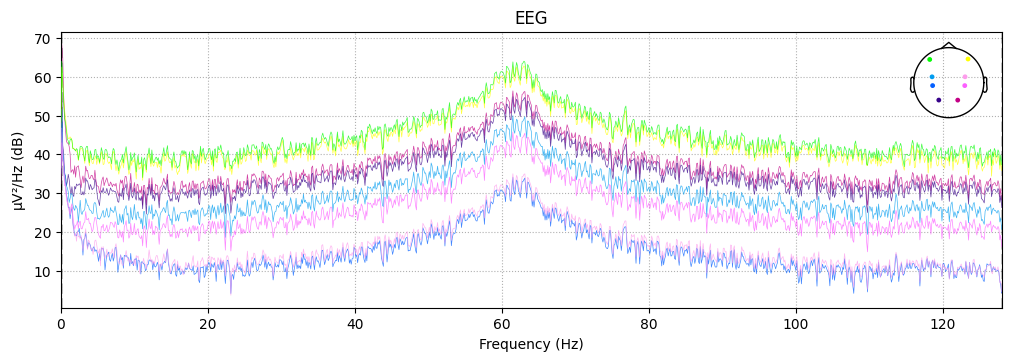

In [5]:
def df_to_raw(df):
    sfreq = 256  #our Neurosity headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T 
    df[:-1] *= 1e-6  #convert from uVolts to Volts 

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #plotting power spectral density
    raw.compute_psd().plot()

    return raw
raw = df_to_raw(df)

In [6]:
raw.filter(1,18, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 18 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 18.00 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,"8 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,1.00 Hz
Lowpass,18.00 Hz


In [7]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [8]:
event_id = {'Non-Target': 1, 'Target' : 2} #changed nontarget from 1 to 0
tmin = -0.1 # tmin and tmax are changeable so we can always do that
tmax = 0.6 
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks)

100 events found on stim channel Marker
Event IDs: [1 2]
sample drop %:  1.0000000000000009


In [9]:
print(len(epochs))


99


[2 2 1 1 2 2 2 2 1 2 2 2 1 2 2 1 2 1 1 1 1 2 1 1 2 1 2 2 1 2 1 2 2 1 2 2 2
 1 2 1 2 1 1 1 2 1 1 2 2 2 1 1 2 2 2 2 2 2 2 1 2 2 1 1 1 2 1 2 1 1 2 1 1 1
 1 1 2 2 1 2 1 1 1 1 2 1 1 2 1 2 1 2 2 1 1 1 1 2 1]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


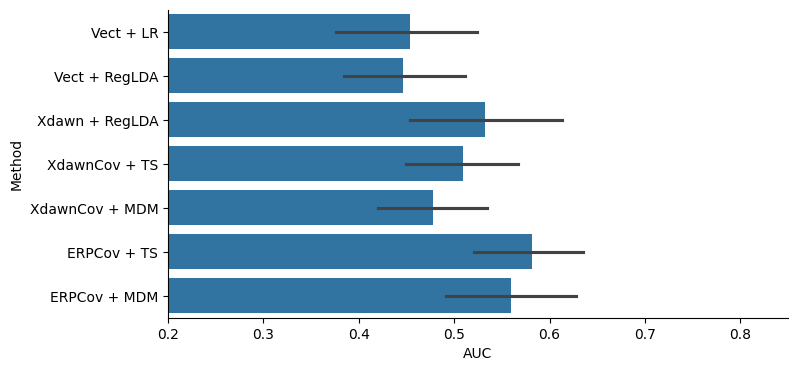

In [10]:
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())


clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())
print(epochs.events[:, -1])

epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()
plt.show()